In [537]:
import itertools
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn import model_selection
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler, RobustScaler
from sklearn.model_selection import cross_val_score, train_test_split, cross_val_predict
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, train_test_split, GridSearchCV


# Import the Data

Here, we import both "heart" and o2Saturation datasets and combine them into one dataframe. 

In [538]:
heart_file_path = "/Users/anna-alexandradanchenko/Documents/University/Second Year/Data Science/HeartAttackAnalysis/input/heart.csv"
o2_file_path = "/Users/anna-alexandradanchenko/Documents/University/Second Year/Data Science/HeartAttackAnalysis/input/o2Saturation.csv"

df_data = pd.read_csv(heart_file_path)

df_o2 = pd.read_csv(o2_file_path)
df_o2 = df_o2.rename(columns={"98.6": "satlvl"})

df_data["satlvl"] = df_o2["satlvl"]
df_data = df_data.rename(columns={"thalachh": "max_heart_rate", "fbs": "fasting_blsugar", "trtbps": "rest_blpressure"})
df_data.head(10)

,age,sex,cp,rest_blpressure,chol,fasting_blsugar,restecg,max_heart_rate,exng,oldpeak,slp,caa,thall,output,satlvl
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1,98.6
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1,98.6
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1,98.6
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1,98.1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1,97.5
5,57,1,0,140,192,0,1,148,0,0.4,1,0,1,1,97.5
6,56,0,1,140,294,0,0,153,0,1.3,1,0,2,1,97.5
7,44,1,1,120,263,0,1,173,0,0.0,2,0,3,1,97.5
8,52,1,2,172,199,1,1,162,0,0.5,2,0,3,1,97.5
9,57,1,2,150,168,0,1,174,0,1.6,2,0,2,1,97.5


# Handling Missing Data and Duplicates
As can be seen from the code below, there are no missing data and only one duplicate, therefore we can conclude that further cleaning is not necessary. Additionally, we move the target column "output" to the last place in the columns order, so it would be easier to work with data. 

In [539]:
count_nan_in_df = df_data.isnull().sum()
print(count_nan_in_df)

count_duplicates = df_data.duplicated().value_counts()
print(count_duplicates)
df_data.drop_duplicates(keep='first',inplace=True)

column_to_move = 'output'
new_order = [col for col in df_data.columns if col != column_to_move] + [column_to_move]
df_data = df_data[new_order]


age                0
sex                0
cp                 0
rest_blpressure    0
chol               0
fasting_blsugar    0
restecg            0
max_heart_rate     0
exng               0
oldpeak            0
slp                0
caa                0
thall              0
output             0
satlvl             0
dtype: int64
False    302
True       1
Name: count, dtype: int64


# Correlation Evaluation and Feature Selection 
## Correlation of Variables with Output

Let us evaluate the correlation of each feature with the target. The graph below provides a valuable visualization showcasing the correlation coefficient of each variable, which will help us in feature engeneering process. 

As can be seen from the graph, the "fasting_blsugar" is the feature wich has the least direct impact on the target variable, while "cp" and "exng" have the highest impact. 

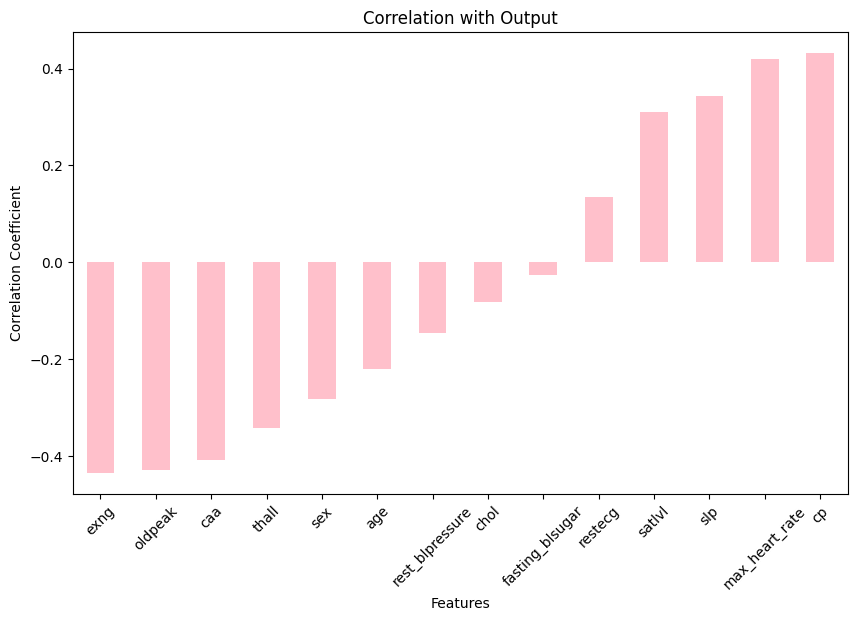

In [540]:
data_corr = df_data.corr()['output'][:-1].sort_values() # -1 means that the latest row is SalePrice
# top_features = data_corr[abs(data_corr) > 0.2].sort_values(ascending=False) #displays pearsons correlation coefficient greater than 0.2
# print("There is {} strongly correlated values with SalePrice:\n{}".format(len(top_features), top_features))

plt.figure(figsize=(10, 6))
data_corr.plot(kind='bar', color='pink')
plt.title('Correlation with Output')
plt.ylabel('Correlation Coefficient')
plt.xlabel('Features')
plt.xticks(rotation=45)
plt.show()

## Correlation Matrix Heatmap

Now, to examine how features correlate with one another, we build a correlation matrix and visualize it in a form of a heatmap. 

It is evident from the graph that there is generally no strong correlation between the features, therefore there is no need to drop any of them for now. 

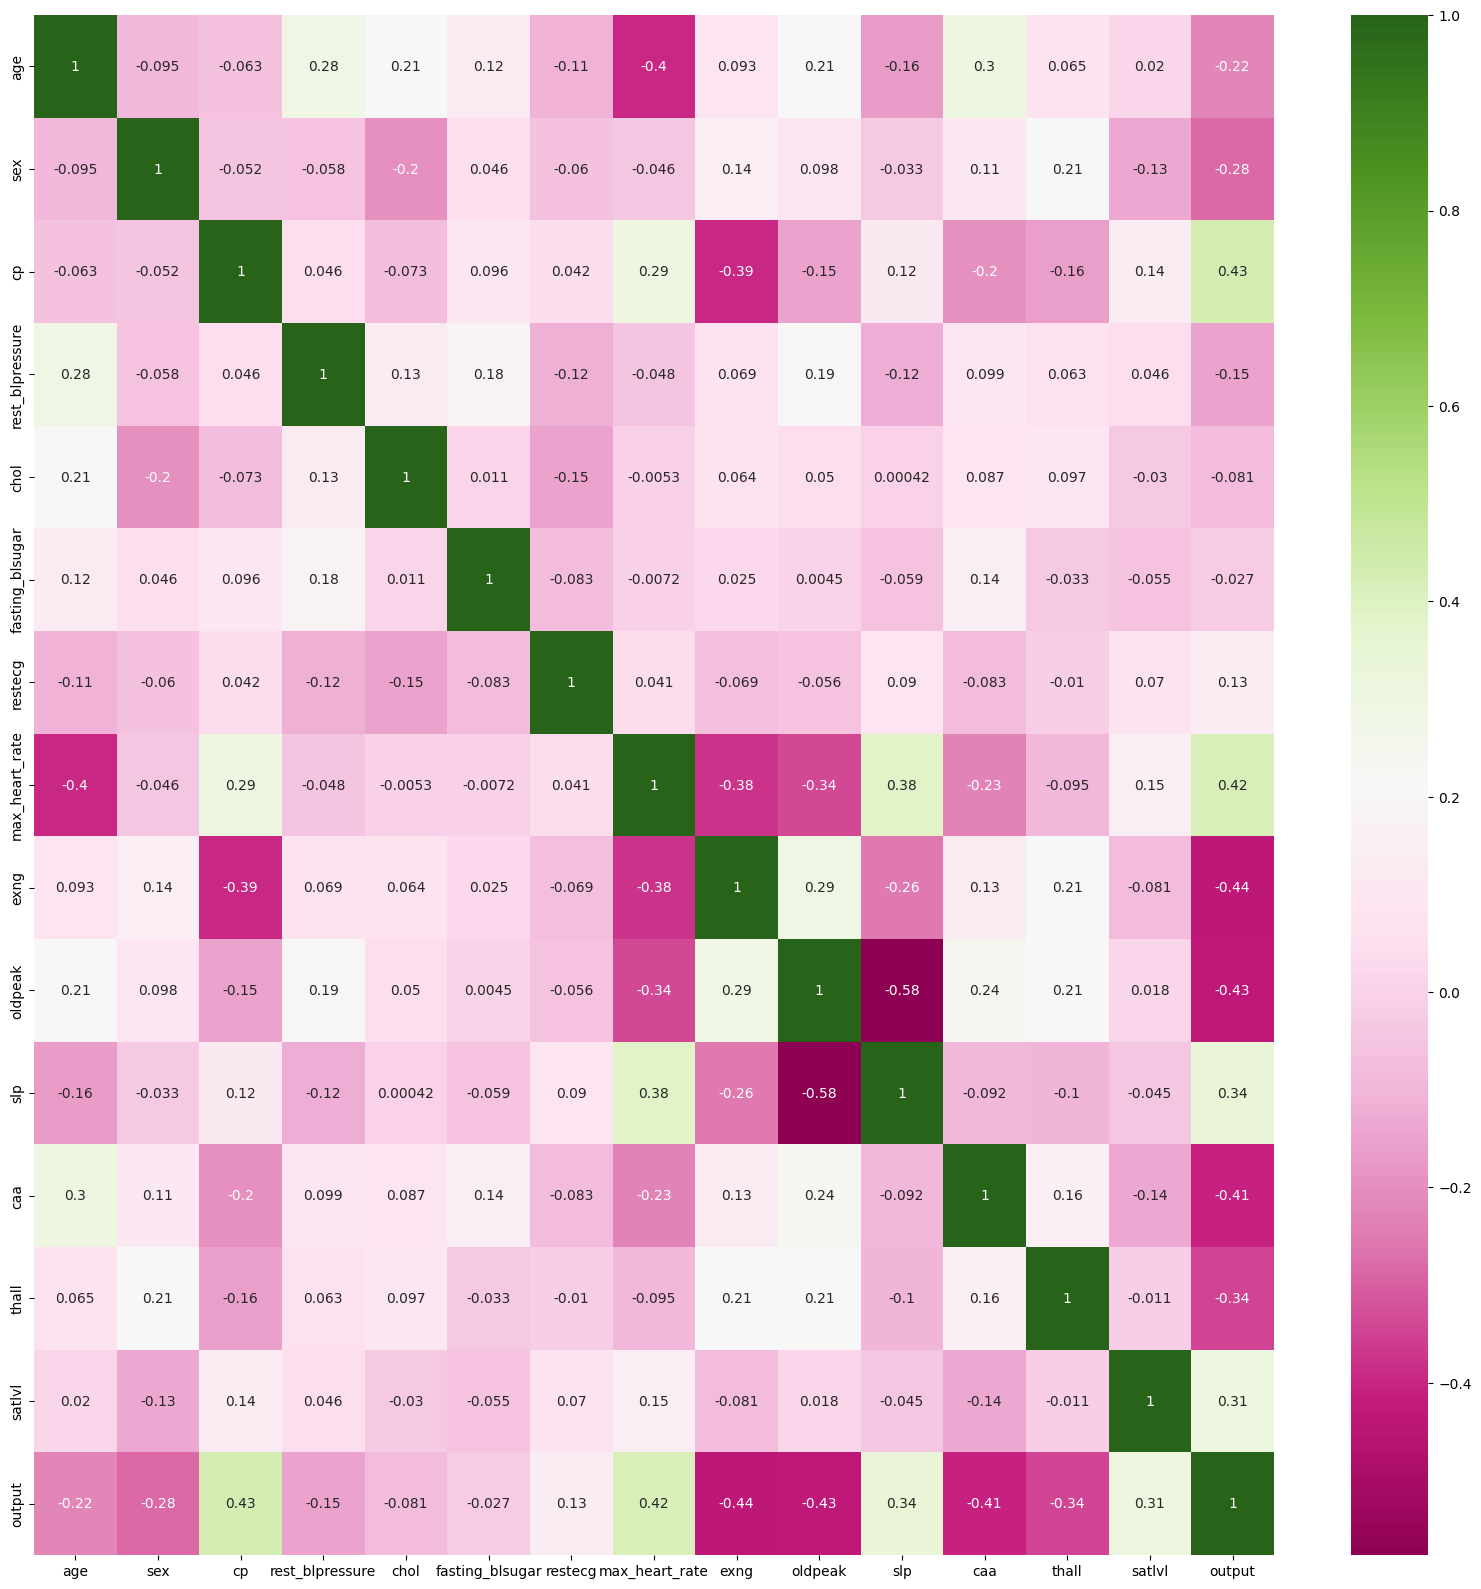

In [541]:
corrMatrix = df_data.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(corrMatrix, annot=True, cmap="PiYG")
plt.show()

# Variables Distribution

age                 41
sex                  2
cp                   4
rest_blpressure     49
chol               152
fasting_blsugar      2
restecg              3
max_heart_rate      91
exng                 2
oldpeak             40
slp                  3
caa                  5
thall                4
satlvl               7
output               2
dtype: int64
The following columns are low cardinality columns: ['sex', 'cp', 'fasting_blsugar', 'restecg', 'exng', 'slp', 'caa', 'thall', 'satlvl', 'output']


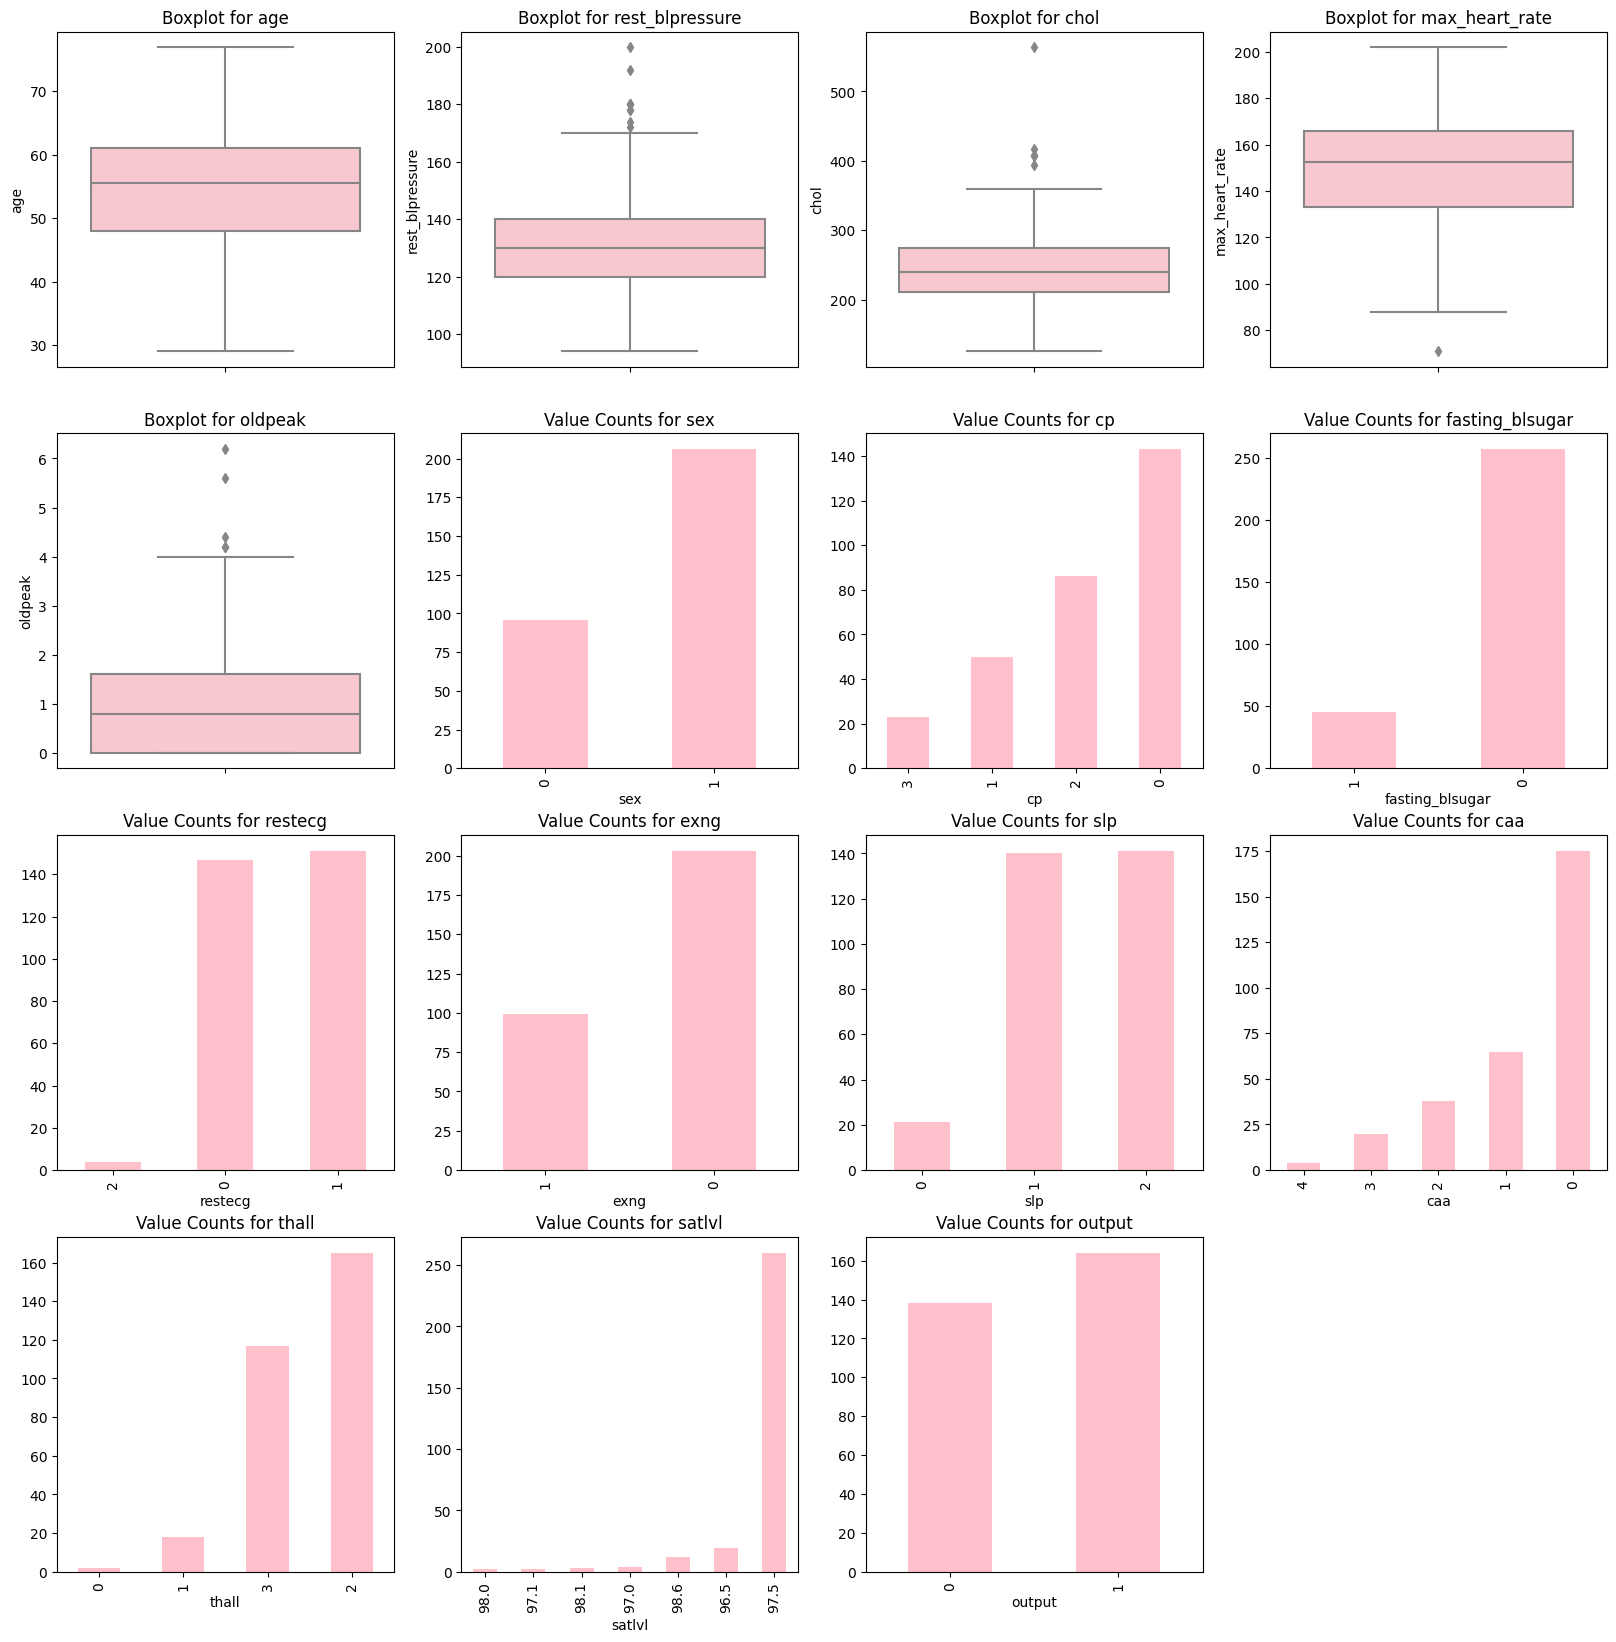

In [542]:
nunique_cnt = df_data.nunique()
print(nunique_cnt)

low_card_cols = nunique_cnt[nunique_cnt < 15].index.tolist()
high_card_cols = nunique_cnt[nunique_cnt >= 15].index.tolist()
print("The following columns are low cardinality columns: " + str(low_card_cols))

# Determine the total number of plots
total_plots = len(high_card_cols) + len(low_card_cols)

# Determine the number of rows and columns on the grid. It outputs integer, as it the numbers should be equal. 
# We choose a square grid that can fit all plots, or a rectangular one that's as close to square as possible
grid_size = int(np.ceil(np.sqrt(total_plots)))
# Create a figure with the grid layout
plt.figure(figsize=(20, 20))

# Plotting high cardinality columns
for i, column in enumerate(high_card_cols):
    plt.subplot(grid_size, grid_size, i + 1)
    sns.boxplot(y=df_data[column], color="pink")
    plt.title(f'Boxplot for {column}')

# Plotting low cardinality columns
for i, column in enumerate(low_card_cols):
    plt.subplot(grid_size, grid_size, i + len(high_card_cols) + 1)
    column_value_counts = df_data[column].value_counts().sort_values()
    column_value_counts.plot(kind='bar', color='pink')
    plt.title(f'Value Counts for {column}')

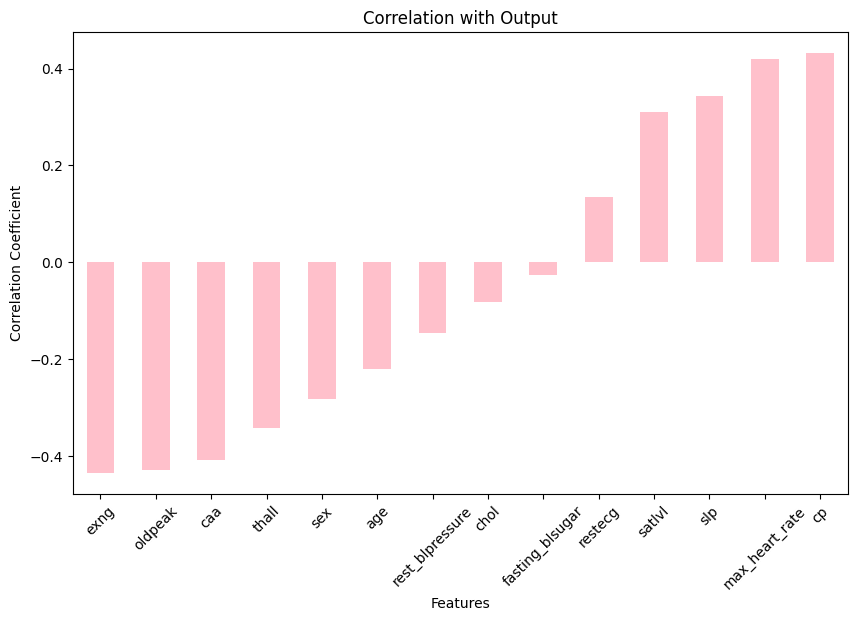

In [543]:


plt.figure(figsize=(10, 6))
data_corr.plot(kind='bar', color='pink')
plt.title('Correlation with Output')
plt.ylabel('Correlation Coefficient')
plt.xlabel('Features')
plt.xticks(rotation=45)
plt.show()

In [544]:
# model = LogisticRegression(max_iter=4000)

# rfecv = RFECV(
#     estimator=model,
#     scoring="accuracy",
#     cv = 5,
#     n_jobs=-1,
# )

# rfecv.fit(X, y)
# print(f"Optimal number of features: {rfecv.n_features_}")

# print(f"Features selected: {X.columns[rfecv.support_]}")

# n_scores = len(rfecv.cv_results_["mean_test_score"])

# plt.figure()
# plt.xlabel("Number of features selected")
# plt.ylabel("Mean test accuracy")
# plt.errorbar(
#     range(1, n_scores + 1),
#     rfecv.cv_results_["mean_test_score"],
#     marker='o', 
#     markersize=5
# )

# plt.title("Recursive Feature Elimination \nwith correlated features")
# plt.show()

# Values Encoding and Data Preparation

In [545]:
X = df_data.drop("output", axis = 1)
y = df_data["output"]

# Model Development

Now, we will compare the performance of different models and establish a baseline based on the results. Firstly, we will create an array with models that we want to test performance for. We won't specify any hyperparameters for mow, so the model will be fit with basic hyperparameters. 

However, the maximum number of iterations is specified for Logistic Regression model, as is needs more iterations than the basic amount to reach convergence. 

In [546]:
models = []
models.append(('LR', LogisticRegression(max_iter=3000)))
models.append(('KNN', KNeighborsClassifier()))
models.append(('RFC', RandomForestClassifier()))
models.append(('NB', GaussianNB()))

Lets create a function that will calculate basic performance scores such as accuracy, preciion, recall and F1. This function will evaluate scores using cross validation with 5 folds. 


In [547]:
def performance_score(X, y, model):

    accuracy_score = cross_val_score(model, X, y, cv=5, scoring='accuracy')
    print(f"Accuracy: {np.mean(accuracy_score):.3f}")

    precision_score = cross_val_score(model, X, y, cv=5, scoring='precision')
    print(f"Precision: {np.mean(precision_score):.3f}")

    recall_score = cross_val_score(model, X, y, cv=5, scoring='recall')
    print(f"Recall: {np.mean(recall_score):.3f}")

    f1_score = cross_val_score(model, X, y, cv=5, scoring='f1')
    print(f"F1: {np.mean(f1_score):.3f}")

Now, let's evaluate performance scores for each model we chose to test. 

In [548]:
for name, model in models:
    print(f"{name} scores")
    performance_score(X, y, model)
    print()

LR scores
Accuracy: 0.825
Precision: 0.822
Recall: 0.872
F1: 0.844

KNN scores
Accuracy: 0.642
Precision: 0.656
Recall: 0.720
F1: 0.686

RFC scores
Accuracy: 0.818
Precision: 0.834
Recall: 0.830
F1: 0.836

NB scores
Accuracy: 0.785
Precision: 0.808
Recall: 0.805
F1: 0.803



As can be observed from the output, Logistic Regression model has similar performance to the random forest. However, it is much faster and should perform better after hyperparameter tuning and feature transformation, therefore it will be the model of our choice. 

## Further Data and Model Improvements

Let's proceed with one-hot encoding for the columns. As can be seen from the output, One-Hot-Encoding improved our accuracy, precision and F1 scores. 

In [549]:
low_card_cols.remove("satlvl")
low_card_cols.remove("output")

encoded_data = pd.get_dummies(df_data[low_card_cols], columns = low_card_cols, drop_first=False)
encoded_data = encoded_data.astype(int)

df_data.drop(low_card_cols, axis = 1, inplace = True)
df_data = pd.concat([df_data, encoded_data], axis = 1)

X = df_data.drop("output", axis = 1)
y = df_data["output"]

performance_score(X, y, LogisticRegression(max_iter=3000))

Accuracy: 0.844
Precision: 0.850
Recall: 0.872
F1: 0.859


Normalize the data. After the data normalization, the performance scores of our model grew a bit, which is a good sign.

In [550]:
scaler = MinMaxScaler(feature_range = (0,1))

nunique_cnt_X = X.nunique()
two_value_cols = nunique_cnt_X[nunique_cnt_X == 2].index.tolist()

cols_to_scale = [col for col in X.columns if col not in two_value_cols]

X_scaled = scaler.fit_transform(X[cols_to_scale])
X_scaled_df = pd.DataFrame(X_scaled, columns=cols_to_scale, index=X.index)

X = pd.concat([X.drop(cols_to_scale, axis=1), X_scaled_df], axis=1)

performance_score(X, y, LogisticRegression(max_iter=3000))

Accuracy: 0.851
Precision: 0.858
Recall: 0.872
F1: 0.863


Now, let's transform some of our features that still have outliers. We will transform resting blood pressure and cholesterol using log transformation.

In [551]:
X_log = X.copy()

# Add a small constant to avoid log(0
X_log["rest_blpressure"]= np.log(X.rest_blpressure + 0.00001)
X_log["chol"]= np.log(X.chol + 0.00001)

performance_score(X_log, y, LogisticRegression(max_iter=3000))

X =X_log.copy()

Accuracy: 0.857
Precision: 0.865
Recall: 0.878
F1: 0.870


### Hyperparameter Tuning using Randomized Search

Now, we will try to improve our model by finding the best hyperparameters using GridSearchCV.

In [552]:
solver = ['lbfgs', 'newton-cg', 'liblinear']
warm_start = [True, False]
C_new = np.logspace(1, 3, num=100)

# combinations = list(itertools.product(range(1, 11), repeat=2))
# random.shuffle(combinations)
# random_combinations = combinations[:10]
# class_weight_dicts = [{0: combo[0], 1: combo[1]} for combo in random_combinations]


hyperparameters = dict(C=C_new, warm_start=warm_start, solver=solver)

rf_random = GridSearchCV(estimator = LogisticRegression(max_iter=3000), cv=5, param_grid=hyperparameters, n_jobs=-1)
rf_random.fit(X, y)

model_random = rf_random.best_estimator_

performance_score(X, y, model_random)

print(rf_random.best_estimator_)

Accuracy: 0.867
Precision: 0.881
Recall: 0.878
F1: 0.877
LogisticRegression(C=10.0, max_iter=3000, solver='liblinear', warm_start=True)


## Final Model

In [553]:
model = LogisticRegression(C=10, max_iter=1000, warm_start=True, solver='liblinear', class_weight={0: 9, 1: 10})
model.fit(X, y)

performance_score(X, y, model)

Accuracy: 0.868
Precision: 0.881
Recall: 0.878
F1: 0.876


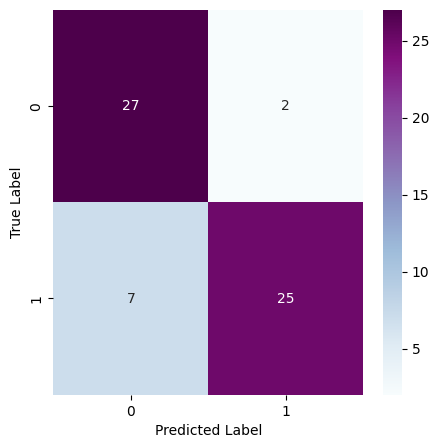

In [554]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

model.fit(X_train, y_train)
y_preds = model.predict(X_test)


confMat = confusion_matrix(y_test, y_preds)
plt.figure(figsize=(5, 5))

sns.heatmap(confMat, annot=True, cmap="BuPu")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

plt.show()